# Source code

In [1]:
import matplotlib
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pyqtgraph as pg
import cv2
import skimage
from scipy.ndimage.filters import median_filter, gaussian_filter
from scipy.ndimage.measurements import label, maximum_position, center_of_mass
from scipy import constants
import matplotlib.colors as colors
import cbc
import cbc_dp

In [2]:
class ROI(object):
    def __init__(self, roi):
        self.roi = roi
        
    @property
    def index(self): return (slice(self.roi[0], self.roi[1]), slice(self.roi[2], self.roi[3]))
    
    def mask(self, shape):
        mask = np.zeros(shape, dtype=np.uint8)
        mask[self.index] = 1
        return mask
    
    def __getitem__(self, index): return self.roi[index]
    
def loadlines(file):
    idxs = list(file[linespath])
    idxs.sort()
    return [file[linespath][idx][:] for idx in idxs]

def loadintensities(file):
    idxs = list(file[intspath])
    idxs.sort()
    return [file[intspath][idx][:] for idx in idxs]

In [3]:
peaks_path = "exp_results/scan_{0:05}/scan_peaks_{0:05}.h5"
cor_path = "exp_results/scan_{0:05}/scan_corrected_{0:05}.h5"
bgd_path = 'corrected_data/background'
cor_data_path = 'corrected_data/corrected_data'
strks_path = 'corrected_data/streaks_data'
data_path = 'data/data'
mask_path = 'data/mask'
lines_path = 'peaks_data/bragg_lines'
ints_path = 'peaks_data/bragg_intensities'
pupil_roi = ROI(np.array([1070, 1250, 1250, 1600]))
pupil_size = (np.radians(0.74), np.radians(1.6))
lys_roi = ROI(np.array([500, 1767, 800, 2070]))
b12_roi = ROI(np.array([700, 2167, 600, 2070]))
b12_zero, lys_zero = np.array([1470, 1710]), np.array([1480, 1155])
full_roi = ROI(np.array([0, 2167, 0, 2070]))
b12_dist, lys_dist = 101.97604579545913, 150.0
pix_size = 75 * 1e-3
wavelength = constants.h * constants.c / 17000 / constants.e * 1e3
rot_axis = [0, 1, 0]
a, b, c = np.array([16.18, 0, 0]) * 1e-7, np.array([0, 21.23, 0]) * 1e-7, np.array([0, 0, 24.33]) * 1e-7

b12_exp = cbc_dp.ExperimentSettings(axis=rot_axis,
                                    pix_size=pix_size,
                                    det_dist=b12_dist,
                                    wavelength=wavelength)
lys_exp = cbc_dp.ExperimentSettings(axis=rot_axis,
                                    pix_size=pix_size,
                                    det_dist=lys_dist,
                                    wavelength=wavelength)

In [4]:
f135 = h5py.File(cor_path.format(135), 'r')
b12_cor_data = f135[cor_data_path]
b12_data = f135[data_path]
b12_mask = f135[mask_path][:]
b12_bgd = f135[bgd_path]
b12_strks_data = f135[strks_path][:]

In [7]:
f107 = h5py.File(cor_path.format(107), 'r')
lys_cor_data = f107[cor_data_path]
lys_bgd = f107[bgd_path]
lys_strks_data = f107[strks_path][:]

In [8]:
f133 = h5py.File(cor_path.format(133), 'r')
b12_cor_data2 = f133[cor_data_path]
b12_bgd2 = f133[bgd_path]
b12_strks_data2 = f133[strks_path][:]

# Line detection

In [11]:
strks = b12_strks_data[90]
strks2 = b12_strks_data2[0]
nms = cbc_dp.NMS(strks.astype(np.float64))
houghdet = cbc_dp.HoughLineDetector(threshold=15, line_length=15, line_gap=3, dth=np.pi/200)
lsd = cbc_dp.LineSegmentDetector()

In [ ]:
%matplotlib qt
fig, axes = plt.subplots(1, 2, figsize=(18, 9))
axes[0].imshow(f135[data_path][96], vmax=100)
axes[1].imshow(f133[data_path][6], vmax=50)
plt.ioff()
plt.show()

In [ ]:
framelns1 = lsd.detectFrame(strks, b12zero, drtau=20, drn=10)
framelns2 = lsd.detectFrame(strks2,)

In [30]:
strkslist = []
strkslist.append(houghdet.detectFrame(strks, b12zero, drtau=20, drn=10))
strkslist.append(houghdet.detectFrame(nms, b12zero, drtau=20, drn=10))
strkslist.append(lsd.detectFrame(strks, b12zero, drtau=20, drn=10))
strkslist.append(lsd.detectFrame(nms, b12zero, drtau=20, drn=10))
ptslist = [strks.indexpoints() for strks in strkslist]

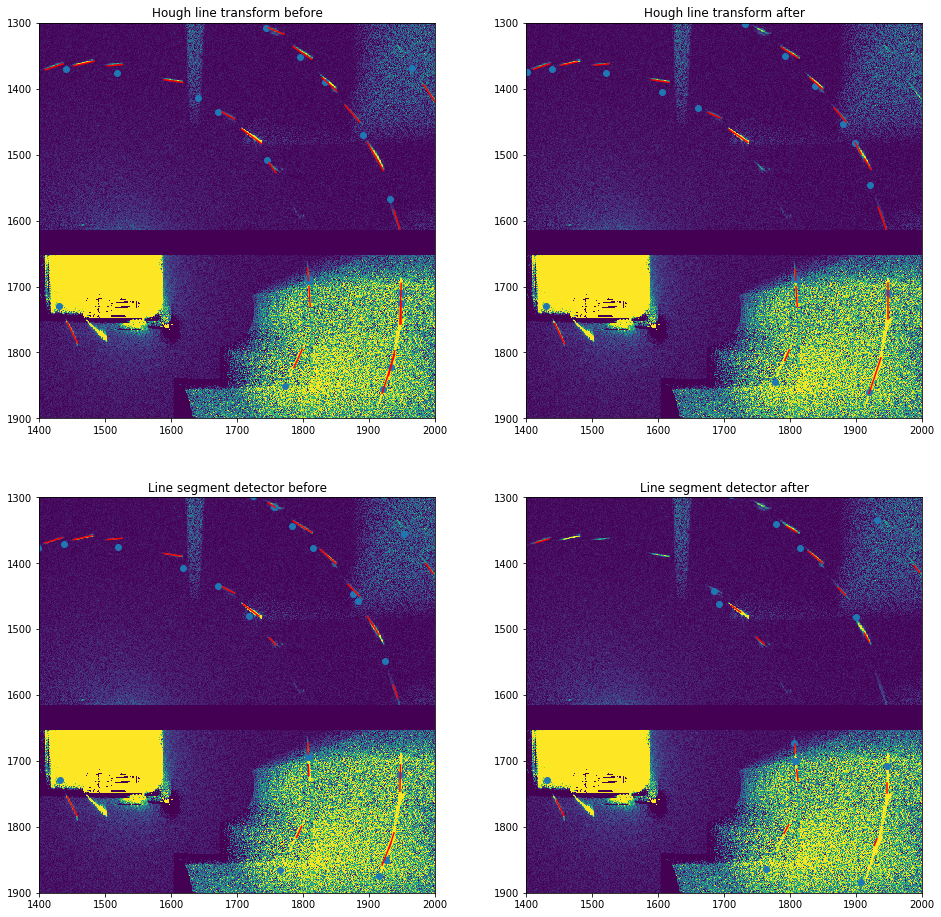

In [32]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
titles = ['Hough line transform before', 'Hough line transform after', 'Line segment detector before', 'Line segment detector after']
for ax, lines, pts, title in zip(axes.ravel(), strkslist, ptslist, titles):
    ax.imshow(image, vmax=200)
    for line in lines:
        ax.plot(line[:, 0], line[:, 1], 'r')  
    ax.scatter(pts[:, 0], pts[:, 1])
    ax.set_xlim(1400, 2000)
    ax.set_ylim(1900, 1300)
    ax.set_title(title)
plt.show()

# Indexing

In [5]:
lsd = cbc_dp.LineSegmentDetector()
b12_scan = lsd.det_scan(b12_strks_data, b12_zero, drtau=20, drn=10)
b12_qs = b12_scan.kout_ref(exp_set=b12_exp,
                           theta=np.radians(np.arange(101)),
                           pixels=25)
snr = b12_scan.snr(b12_data * f135[mask_path][:], b12_bgd)

In [6]:
size = 100
b12_grid = cbc_dp.utils.make_grid(b12_qs.scat_vec, np.ones(b12_qs.scat_vec.shape[0]), size)
# b12_grid = cbc_dp.utils.make_grid(b12_qs.scat_vec, np.log(snr), size)
b12_fs = (np.abs(np.fft.fftshift(np.fft.fftn(b12_grid)))**2)

In [7]:
%gui qt
app = cbc_dp.Qt.make_app()
w = cbc_dp.Qt.VolumeViewer()
w.set_data(data=cbc_dp.Qt.vol_data(b12_grid, alpha=1))
w.show()

In [39]:
%gui qt
app = cbc_dp.Qt.make_app()
w = cbc_dp.Qt.ScatterViewer()
w.set_data(pos=b12_qs.scat_vec, size=3)
w.show()

In [8]:
b12_blur = gaussian_filter(b12_fs.astype(np.float64), 4)
b12_mask = b12_blur > b12_blur.mean() + 3. * b12_blur.std()
b12_crop = np.where(b12_mask, b12_blur, 0)
b12_labels, b12_num_labels = label(b12_mask)
b12_centers = np.array(maximum_position(b12_blur,
                                        labels=b12_labels,
                                        index=np.arange(1, b12_num_labels + 1))) - size / 2 * np.ones(3)
mask = np.array([center.dot(center) for center in b12_centers]).argsort()[:7]
axes = (b12_centers * (b12_qs.range)**-1)[mask[[1, 3, 5]]]

In [42]:
%gui qt
app = cbc_dp.Qt.make_app()
w = cbc_dp.Qt.VolumeViewer()
w.set_data(data=cbc_dp.Qt.vol_data(b12_crop))
w.show()

In [10]:
%gui qt
app = cbc_dp.Qt.make_app()
w = cbc_dp.Qt.ScatterViewer()
w.set_data(pos=b12_centers[mask], size=10)
w.show()

In [10]:
b12_axes = np.array([[16.18, 0, 0],
                     [0, 21.23, 0],
                     [0, 0, 24.33]]) * 1e-7
for ax, b12_ax in zip(axes, b12_axes):
    print(np.sqrt(ax.dot(ax))**-1, wavelength / np.sqrt(b12_ax.dot(b12_ax)), sep='\t')

0.046673935497867865	0.0450753280725686
0.03208255472470748	0.03435321753246161
0.02645142724884562	0.029976112133750923


In [73]:
idx = 90
or_mat = np.stack(cbc.rec_basis(axes[0], axes[1], axes[2]))
rot_m = b12_exp.rotation_matrix(np.radians(-idx))
or_rot = or_mat.dot(rot_m.T)
rec_lat = cbc_dp.RecLattice(or_rot, center=np.zeros(3))
model = cbc_dp.CircModel(rec_lat=rec_lat, num_ap=np.radians(1.), q_max=0.4)
xs, ys = model.detector_pts(b12_dist)

In [74]:
idxs = slice(b12_scan.shapes[idx], b12_scan.shapes[idx + 1])
hkl_exp = rec_lat.hkl_idx(b12_qs.scat_vec).astype(np.int)[idxs]
hkl_sim = model.hkl_idx.astype(np.int)
mask = (hkl_exp[:, None] == hkl_sim[None, :]).all(axis=2)
sim_mask = mask.any(axis=0)
exp_mask = mask.any(axis=1)
print(hkl_exp.shape, hkl_sim.shape, sim_mask.shape)

(70, 3) (101, 3) (101,)


In [75]:
matplotlib.pyplot.switch_backend('Qt5Agg')
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15))
for line, hkl, flag in zip(b12_scan[idx].lines, hkl_exp, exp_mask):
    ax.plot(line[:, 0], line[:, 1], 'r')
    ax.text(line[0, 0], line[0, 1], '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl), color=(1, 0.8, 0.8))
for x, y, hkl, flag in zip(xs / pix_size + b12_zero[0],
                     ys / pix_size + b12_zero[1],
                     hkl_sim, sim_mask):
    ax.plot(x , y, 'b')
    ax.text(x.mean(), y.mean(), '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl), color=(0.8, 0.8, 1))
ax.imshow(b12_cor_data[idx], vmin=0, vmax=50)
ax.set_xlim(800, 2070)
ax.set_ylim(900, 2167)
matplotlib.pyplot.show()

In [76]:
matplotlib.pyplot.switch_backend('Qt5Agg')
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15))
for line, hkl, flag in zip(b12_scan[idx].lines, hkl_exp, exp_mask):
    ax.plot(line[:, 0], line[:, 1], 'r')
    if flag:
        ax.text(line[0, 0], line[0, 1], '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl), color=(1, 0.8, 0.8))
for x, y, hkl, flag in zip(xs / pix_size + b12_zero[0],
                     ys / pix_size + b12_zero[1],
                     hkl_sim, sim_mask):
    ax.plot(x , y, 'b')
    if flag:
        ax.text(x.mean(), y.mean(), '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl), color=(0.8, 0.8, 1))
ax.imshow(b12_cor_data[idx], vmin=0, vmax=50)
ax.set_xlim(800, 2070)
ax.set_ylim(900, 2167)
matplotlib.pyplot.show()

# Streaks grouping

In [80]:
lsd = cbc_dp.LineSegmentDetector()
b12_scan = lsd.det_scan(b12_strks_data, b12_zero, drtau=20, drn=10)
b12_streaks = b12_scan.kout(exp_set=b12_exp, theta=np.radians(np.arange(101)))

In [84]:
txt_file = open('k_out.txt', 'w')
for frame_idx, b12_frame in enumerate(b12_scan):
    txt_file.write('# Frame {:d}\n'.format(frame_idx))
    kouts = b12_exp.rec_project(det_pts=b12_frame.lines.mean(axis=1), zero=b12_frame.zero)
    for kout in kouts:
        txt_file.write('{0[0]:6.3f}\t{0[1]:6.3f}\t{0[2]:6.3f}\n'.format(kout))
txt_file.close()

In [8]:
b12_frame = b12_scan[0]
qs = b12_frame.kout_streaks(exp_set=b12_exp, theta=0)
print(qs.kout.shape, qs.kin.shape)

(81, 2, 3) (81, 2, 3)


In [6]:
b12_size = (b12_rec_strks.rec_vec[:, 1] - b12_rec_strks.rec_vec[:, 0])
angles = np.arctan2(b12_size[:, 1], b12_size[:, 0])
b12_ysize = np.abs(b12_size[(np.abs(angles) > 0.375) | (np.abs(angles) < 0.625)])
b12_xsize = np.abs(b12_size[(np.abs(angles) < 0.125) | (np.abs(angles) > 0.875)])

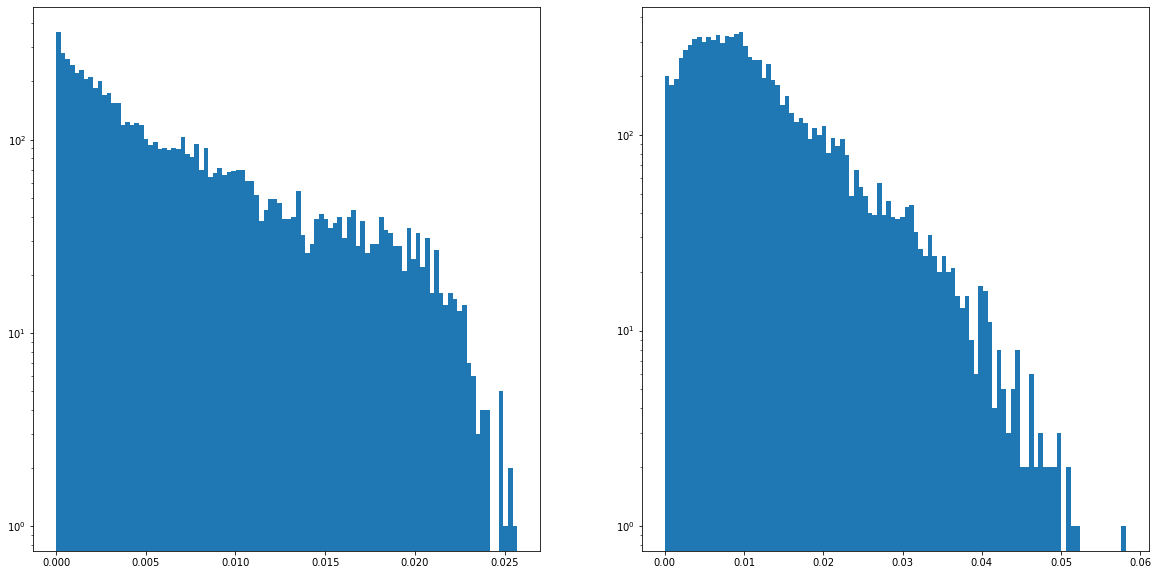

In [74]:
%matplotlib inline
ptl, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].hist(b12_xsize[:, 0], 100, log=True)
axes[1].hist(b12_ysize[:, 1], 100, log=True)
plt.show()

In [7]:
kout_list, kin_list, qs_list = [], [], []
for idx, frame in enumerate(b12_scan[:10]):
    qs = frame.kout(exp_set=b12_exp, theta=np.radians(idx))
    qs_list.append(qs)
    kout_list.append(qs.kout)
    kin_list.append(qs.kin)
groups = cbc_dp.TiltGroups(kout=kout_list, kin=kin_list, threshold=b12_exp.pixtoq(25))
ref_kin = groups.ref_kin()

In [9]:
rec_vec = cbc_dp.RecVectors(kout=np.concatenate(kout_list),
                            kin=np.concatenate(kin_list))
ref_vec = cbc_dp.RecVectors(kout=np.concatenate(kout_list),
                            kin=np.concatenate(ref_kin))

In [16]:
idx = 0
idxs, streaks = [], []
for group in groups.groups:
    group_idxs = group.get_idxs(idx)
    if group_idxs.any():
        idxs.append(group_idxs)
        streaks.append(np.tile(group.index_streak()[None, :], (group_idxs.size, 1)))
idxs, streaks = np.concatenate(idxs), np.concatenate(streaks)

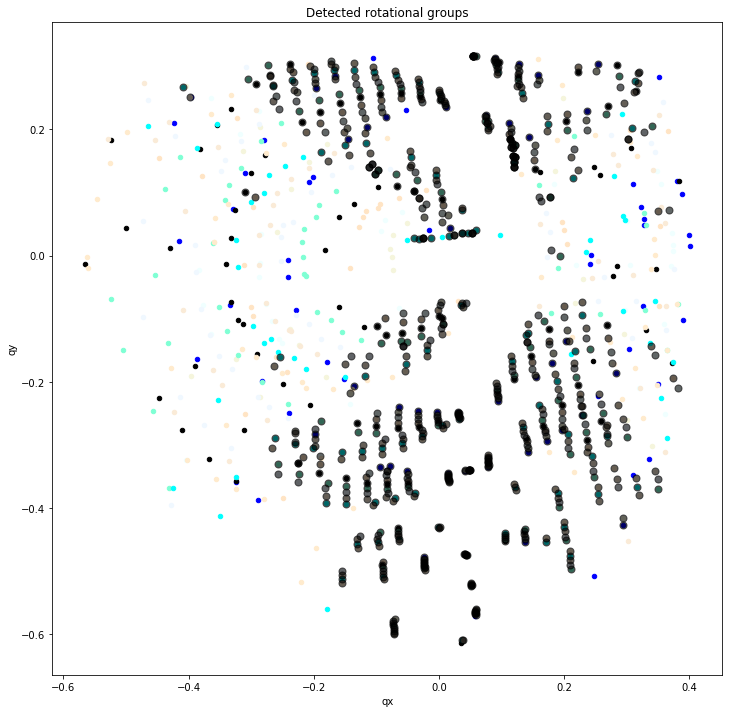

In [17]:
%matplotlib inline
plt.figure(figsize=(12, 12))
color_list = list(colors.CSS4_COLORS.values())[:len(qs_list)]
np.random.shuffle(color_list)
for frame_qs, color in zip(qs_list, color_list):
    plt.scatter(frame_qs.scat_vec[:, 0], frame_qs.scat_vec[:, 1], 20, color)
for group in groups.groups:
    streaks = np.concatenate(group.streaks)
    plt.scatter(streaks[:, 0], streaks[:, 1], 50, 'black', alpha=0.6)
plt.title('Detected rotational groups')
plt.xlabel('qx')
plt.ylabel('qy')
plt.show()

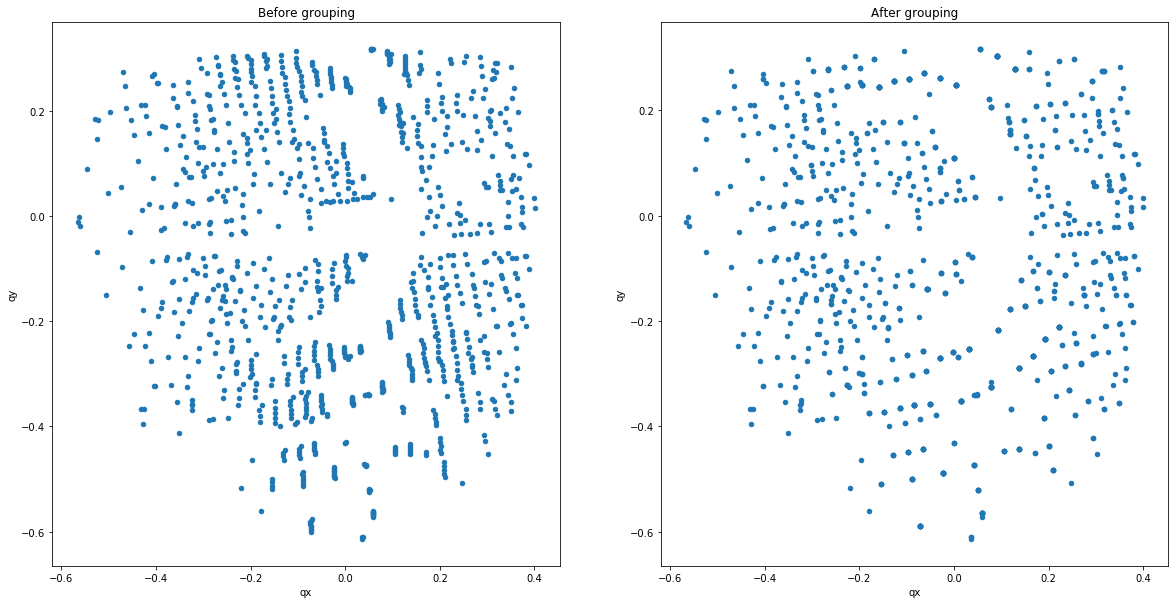

In [10]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].scatter(rec_vec.scat_vec[:, 0], rec_vec.scat_vec[:, 1], 20)
axes[0].set_title('Before grouping')
axes[1].scatter(ref_vec.scat_vec[:, 0], ref_vec.scat_vec[:, 1], 20)
axes[1].set_title('After grouping')
for ax in axes:
    ax.set_xlabel('qx')
    ax.set_ylabel('qy')
plt.show()

# Gradien descend

In [16]:
or_mat2 = np.array([[16.18**-1, 0, 0],
                    [0, 21.23**-1, 0],
                    [0, 0, 24.33**-1]]) * wavelength * 1e7

In [5]:
lsd = cbc_dp.LineSegmentDetector()
b12_scan = lsd.det_scan(b12_strks_data, b12_zero, drtau=20, drn=10)
b12_qs = b12_scan.kout_ref(exp_set=b12_exp,
                           theta=np.radians(np.arange(101)),
                           pixels=25)
axes = b12_qs.index()[[1, 3, 5]]
a_rec, b_rec, c_rec = cbc.rec_basis(axes[0], axes[1], axes[2])
or_mat = np.stack((a_rec, b_rec, c_rec))
or_inv = np.linalg.inv(or_mat)
snr = b12_scan.snr(b12_data[:] * b12_mask, b12_bgd[:])

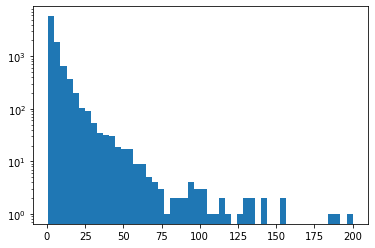

In [96]:
%matplotlib inline
plt.hist(intensities, 50, log=True)
plt.show()

In [118]:
trg_func = TargetFunction(data=b12_qs, snr=snr)
grad_dsnts = {}
grad_dsnts[0] = GradientDescent(or_mat, np.zeros(3), trg_func, step_size=0.02)
for i in range(1, 200):
    grad_dsnts[i] = grad_dsnts[i - 1].next_point()
values = [grad_dsnt.value() for grad_dsnt in grad_dsnts.values()]
points = [grad_dsnt.point for grad_dsnt in grad_dsnts.values()]
print(values[0], values[-1])

0.007025001327794378 0.004522612518381264


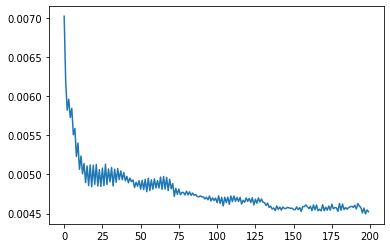

In [119]:
%matplotlib inline
plt.plot(values)
plt.show()

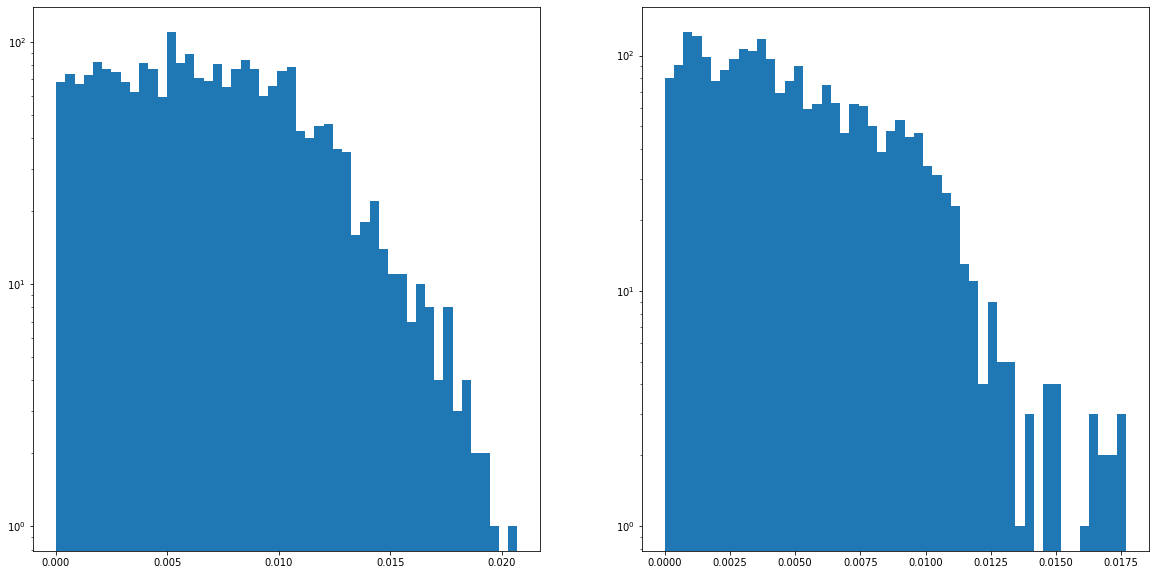

In [120]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].hist(trg_func.values(points[0]), 50, log=True)
axes[1].hist(trg_func.values(points[-1]), 50, log=True)
plt.show()

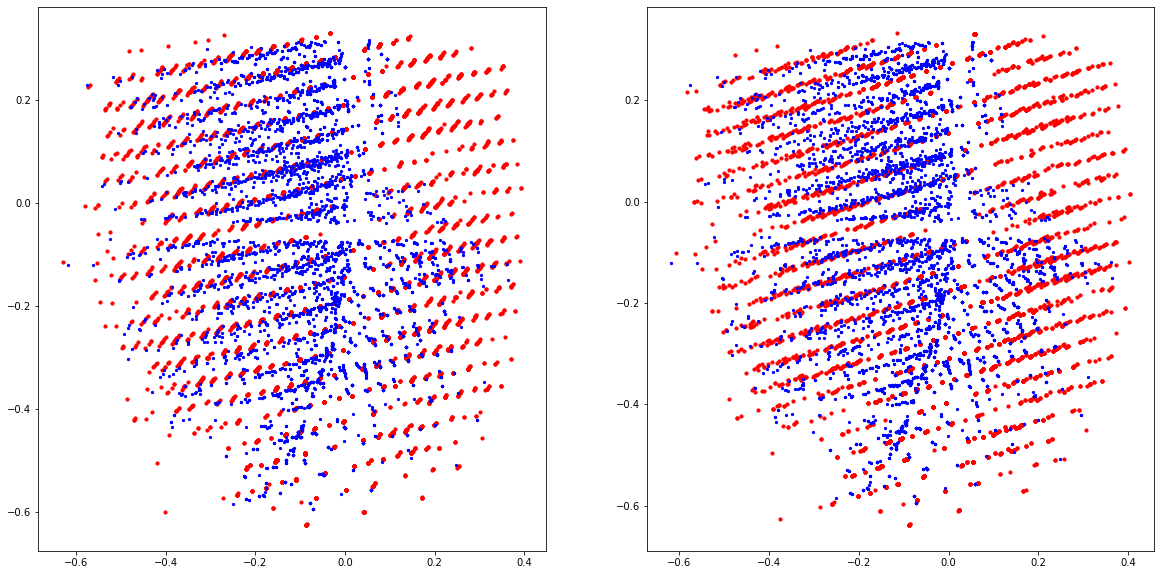

In [121]:
%matplotlib inline
rec_lat = RecLattice(points[0][:3], points[0][3])
qs_model = rec_lat.scat_vec(b12_qs.scat_vec)
rec_lat2 = RecLattice(points[-1][:3], points[-1][3])
qs_model2 = rec_lat2.scat_vec(b12_qs.scat_vec)
idx = 5000
idxs = np.argsort(intensities)[intensities.size // 2:]
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].scatter(qs_model[:idx, 0], qs_model[:idx, 1], 10, 'r')
axes[0].scatter(b12_qs.scat_vec[idxs, 0], b12_qs.scat_vec[idxs, 1], 5, 'b')
axes[1].scatter(qs_model2[:idx, 0], qs_model2[:idx, 1], 10, 'r')
axes[1].scatter(b12_qs.scat_vec[idxs, 0], b12_qs.scat_vec[idxs, 1], 5, 'b')
plt.show()

In [110]:
exp_cell = np.array([16.18, 21.23, 24.33]) * 1e-7
print(np.sqrt((points[0] * points[0]).sum(axis=1)),
      np.sqrt((points[-1] * points[-1]).sum(axis=1)),
      exp_cell**-1 * wavelength,
      sep='\n')

[0.04507533 0.03435322 0.02997611 0.        ]
[0.02736853 0.03472237 0.02958535 0.0085434 ]
[0.04507533 0.03435322 0.02997611]


In [150]:
frame_idx = 0
xs_list, ys_list = [], []
rot_m = b12_exp.rotation_matrix(np.radians(-frame_idx))
for point in [points[0], points[-1]]:
    or_rot = point[:3].dot(rot_m.T)
    rec_lat = RecLattice(or_mat=or_rot, center=point[3])
    model = SquareModel(rec_lat=rec_lat, num_ap=np.radians(1.), q_max=0.4)
    xs, ys = model.detector_pts(b12_dist)
    xs_list.append(xs)
    ys_list.append(ys)

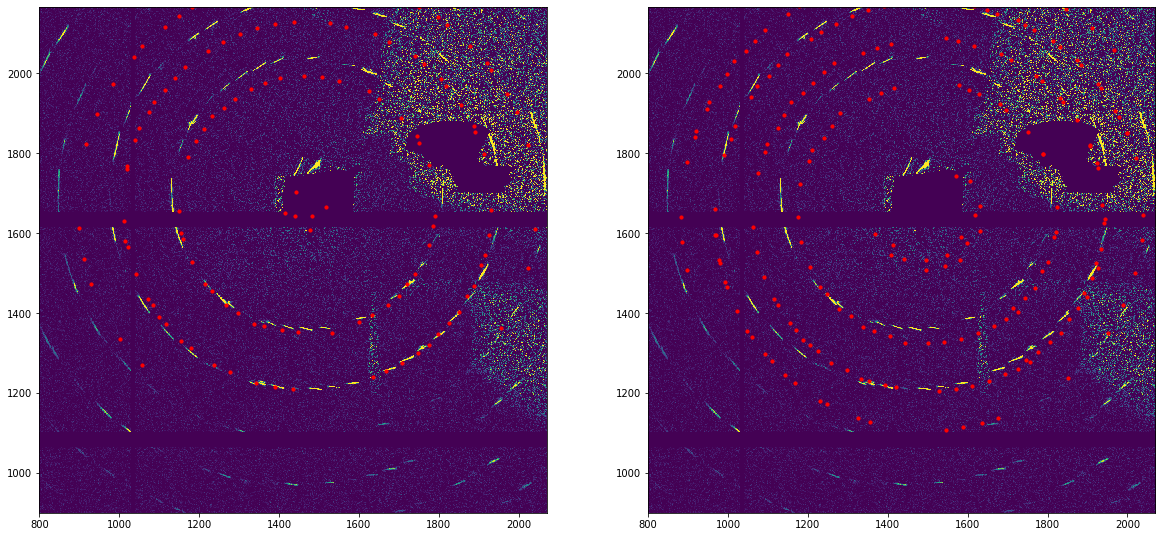

In [151]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].scatter(xs_list[0].mean(axis=1) / pix_size + b12_zero[0],
                ys_list[0].mean(axis=1) / pix_size + b12_zero[1], 10, 'r')
axes[1].scatter(xs_list[-1].mean(axis=1) / pix_size + b12_zero[0],
                ys_list[-1].mean(axis=1) / pix_size + b12_zero[1], 10, 'r')
for ax in axes:
    ax.imshow(b12_cor_data[frame_idx], vmin=0, vmax=50)
    ax.set_xlim(800, 2070)
    ax.set_ylim(900, 2167)
plt.show()

In [89]:
rec_lat = cbc_dp.RecLattice(or_mat=or_mat, center=np.zeros(3))
model = cbc_dp.CircModel(rec_lat=rec_lat, num_ap=np.radians(1.), q_max=0.4)
xs, ys = model.detector_pts(b12_dist)
rec_lat2 = cbc_dp.RecLattice(or_mat=or_mat, center=np.radians(np.array([1., 0, 0])))
model2 = cbc_dp.CircModel(rec_lat=rec_lat2, num_ap=np.radians(1.), q_max=0.4)
xs2, ys2 = model2.detector_pts(b12_dist)

In [123]:
rec_lat = RecLattice(or_mat=or_mat, center=np.zeros(3))
qs_model = rec_lat.scat_vec(b12_qs.scat_vec)
dq = b12_qs.scat_vec - qs_model
dq_abs = np.sqrt((dq * dq).sum(axis=1))
# norm = qs_model - b12_qs.kout
# idxs = np.where(np.sqrt((b12_qs.scat_vec * b12_qs.scat_vec).sum(axis=1)) < 0.4)
# dn = (1 - np.sqrt((norm * norm).sum(axis=1)))[idxs][:, None] * norm[idxs]
# dn2 = ((dq * norm).sum(axis=1) / (norm * norm).sum(axis=1))[:, None] * norm
# target_func = np.sqrt((dn * dn).sum(axis=1))
print(qs_model.shape, dn.shape)

(9351, 3) (6660, 3)


In [126]:
np.radians(1.5)

0.026179938779914945

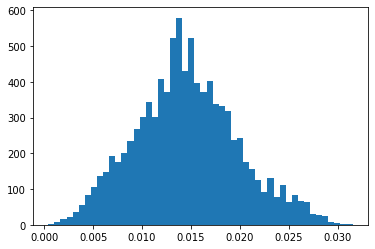

In [124]:
%matplotlib inline
plt.hist(dq_abs, 50)
plt.show()

In [116]:
dtau = dq - dn2
start = 0
for theta, stop in enumerate(b12_scan.shapes):
    rot_m = b12_exp.rotation_matrix(np.radians(-theta))
    dtau[start:stop] = dtau[start:stop].dot(rot_m.T)
    start = stop

In [144]:
%gui qt
app = cbc_dp.Qt.make_app()
w = cbc_dp.Qt.ScatterViewer()
w.set_data(pos=delta_tau)
w.show()

In [94]:
%gui qt
idx = 5000
app = cbc_dp.Qt.make_app()
w = cbc_dp.Qt.ScatterViewer()
w.set_data(pos=np.concatenate((qs_model[:idx], b12_qs.scat_vec[:idx])),
           size=np.concatenate((10 * np.ones(idx), 2 * np.ones(idx))))
w.show()

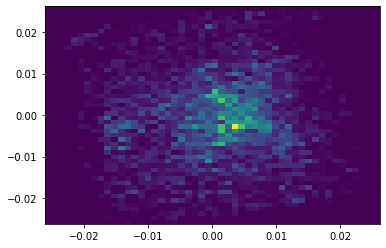

In [118]:
%matplotlib inline
roi = np.radians(1.5) * np.array([[-1, 1], [-1, 1]])
plt.hist2d(dtau[:, 0], dtau[:, 1], bins=50, range=roi)
plt.show()

# Diffraction simulation

In [78]:
mod_scan = []
kins = []
for theta in np.radians(np.arange(101)):
    rot_m = b12_exp.rotation_matrix(-theta)
    or_rot = or_mat.dot(rot_m.T)
    rec_lat = cbc_dp.RecLattice(or_mat=or_rot, center=np.zeros(3))
    model = cbc_dp.CircModel(rec_lat=rec_lat, num_ap=np.radians(1.5), q_max=0.4)
    xs, ys = model.detector_pts(b12_dist)
    lines = np.stack((xs, ys), axis=2) / pix_size
    kin = np.mean((model.entry_pts(), model.exit_pts()), axis=0).T
    kins.append(kin.dot(rot_m))
    strks = cbc_dp.FrameStreaks(lines, np.zeros(2))
    mod_scan.append(strks)
mod_scan = cbc_dp.ScanStreaks(mod_scan)
kins = np.concatenate(kins)
mod_qs_ref = mod_scan.kout_ref(exp_set=b12_exp,
                               theta=np.radians(np.arange(101)),
                               pixels=35)
mod_qs_raw = mod_scan.kout(exp_set=b12_exp,
                           theta=np.radians(np.arange(101)))
mod_qs = cbc_dp.RecVectors(kout=mod_qs_raw.kout, kin=kins)
rec_lat = cbc_dp.RecLattice(or_mat, np.zeros(3))
qs_model = rec_lat.scat_vec(mod_qs.scat_vec)

In [46]:
%gui qt
app = cbc_dp.Qt.make_app()
w = cbc_dp.Qt.ScatterViewer()
w.set_data(pos=mod_qs.scat_vec, size=5)
w.show()

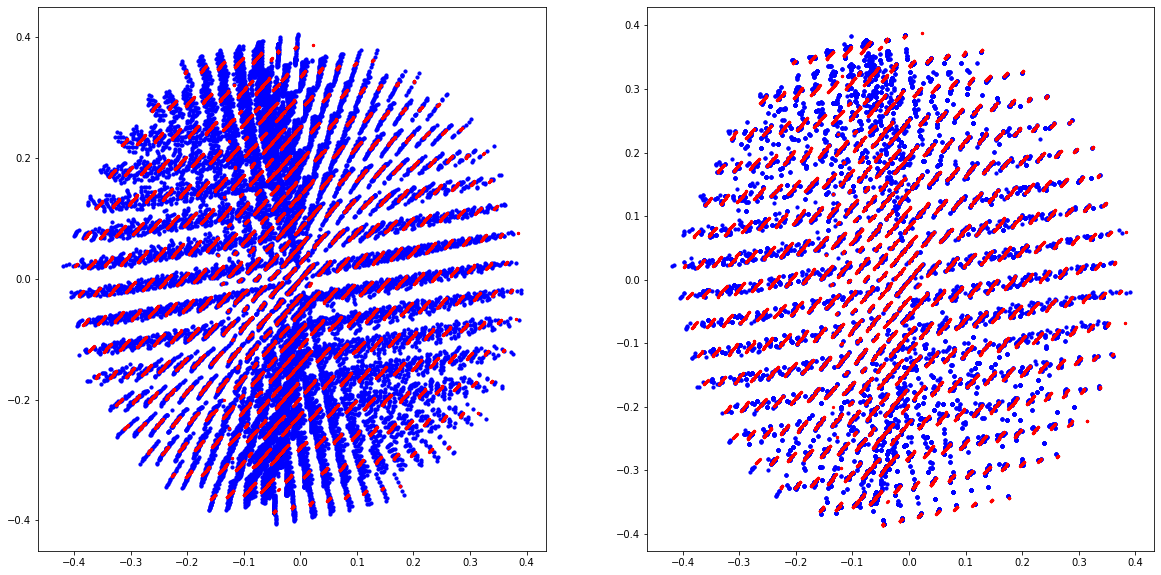

In [79]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].scatter(mod_qs_raw.scat_vec[:, 0], mod_qs_raw.scat_vec[:, 1], 10, 'b')
axes[0].scatter(qs_model[:, 0], qs_model[:, 1], 5, 'r')
axes[1].scatter(mod_qs_ref.scat_vec[:, 0], mod_qs_ref.scat_vec[:, 1], 10, 'b')
axes[1].scatter(qs_model[:, 0], qs_model[:, 1], 5, 'r')
plt.show()

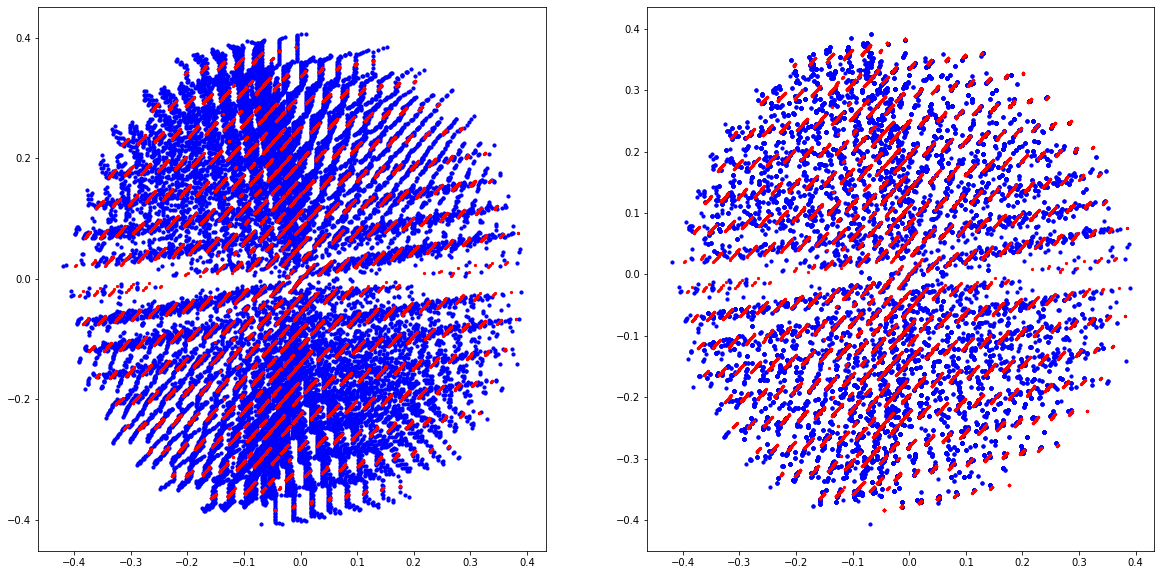

In [93]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].scatter(mod_qs_raw.scat_vec[:, 0], mod_qs_raw.scat_vec[:, 1], 10, 'b')
axes[0].scatter(qs_model[:, 0], qs_model[:, 1], 5, 'r')
axes[1].scatter(mod_qs_ref.scat_vec[:, 0], mod_qs_ref.scat_vec[:, 1], 10, 'b')
axes[1].scatter(qs_model[:, 0], qs_model[:, 1], 5, 'r')
plt.show()

In [65]:
def rec_or(axes):
    """
    Return orientation matrix based on unit cell primitive vectors matrix

    axes - unit cell primitive vectors matrix
    """
    a_rec, b_rec, c_rec = cbc.rec_basis(axes[0], axes[1], axes[2])
    return np.stack((a_rec, b_rec, c_rec))

In [85]:
size = 100
gauss_sigma = 4
threshold = 3
fft_grid = mod_qs_ref.fft(size)
fft_blur = gaussian_filter(fft_grid.astype(np.float64), gauss_sigma)
peak_mask = fft_blur > fft_blur.mean() + threshold * fft_blur.std()
peak_labels, peak_num = label(peak_mask)
peak_centers = np.array(maximum_position(fft_blur,
                                         labels=peak_labels,
                                         index=np.arange(1, peak_num + 1)))
peak_centers = peak_centers - size / 2 * np.ones(3)
axes_mask = np.array([center.dot(center) for center in peak_centers]).argsort()[:11]
centers = (peak_centers * mod_qs_ref.range**-1)[axes_mask]
axes = centers[[1, 3, 9]]

In [86]:
mod_or = rec_or(axes)
mod_or, or_mat

(array([[-0.00928437,  0.04533879,  0.00148683],
        [-0.03122388, -0.00544065, -0.00017842],
        [ 0.00171495,  0.00181355, -0.02616825]]),
 array([[-0.00955958,  0.04569071,  0.00127158],
        [-0.03160975, -0.00589558, -0.00016407],
        [-0.00153314, -0.00164234,  0.02641596]]))

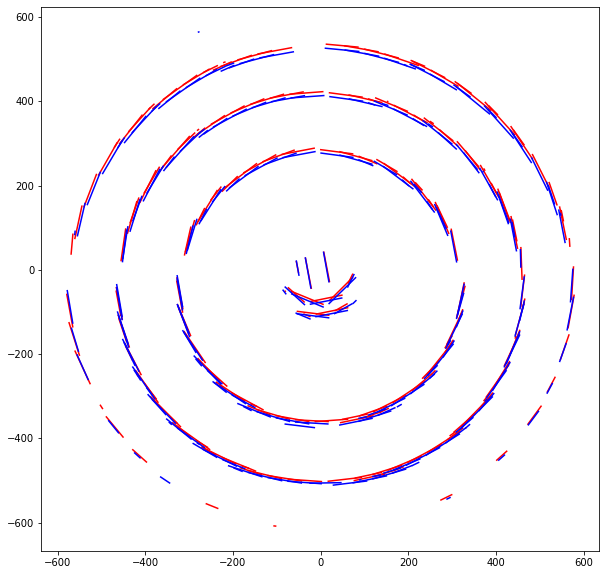

In [91]:
%matplotlib inline
rec_lat = cbc_dp.RecLattice(or_mat=mod_or, center=np.zeros(3))
model = cbc_dp.SquareModel(rec_lat=rec_lat, num_ap=np.radians(1.5), q_max=0.4)
xs, ys = model.detector_pts(b12_dist)
plt.figure(figsize=(10, 10))
for line in mod_scan[0].lines:
    plt.plot(line[:, 0], line[:, 1], 'r')
for x, y in zip(xs, ys):
    plt.plot(x / pix_size, y / pix_size, 'b')
plt.show()

# Peaks sum

In [31]:
lyssum = np.concatenate([lines for lines in lyslines if lines.any()]).mean(axis=1)
b12sum = np.concatenate([lines for lines in b12lines if lines.any()]).mean(axis=1)
lyssumints = np.concatenate([ints for ints in lysints if ints.any()])
b12sumints = np.concatenate([ints for ints in b12ints if ints.any()])

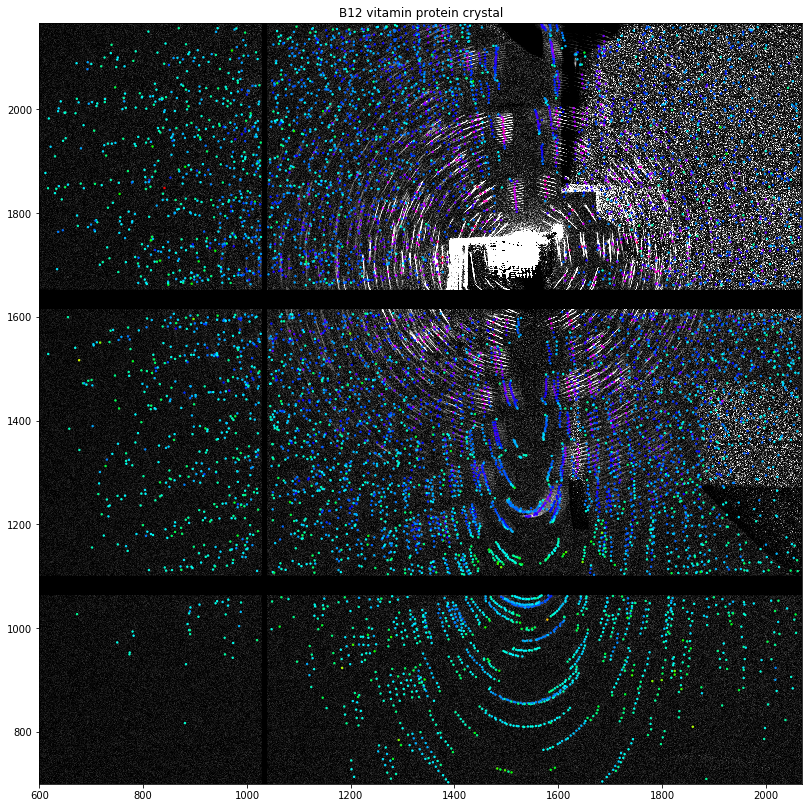

In [32]:
%matplotlib inline
plt.figure(figsize=(14, 14))
plt.imshow(b12data.sum(axis=0), vmin=0, vmax=3000, cmap='gist_gray')
plt.scatter(b12sum[:, 0], b12sum[:, 1], s=2, c=np.log(b12sumints - b12sumints.min() + 1.0), cmap='hsv')
plt.xlim((b12roi.roi[2], b12roi.roi[3]))
plt.ylim((b12roi.roi[0], b12roi.roi[1]))
plt.title('B12 vitamin protein crystal')
plt.show()

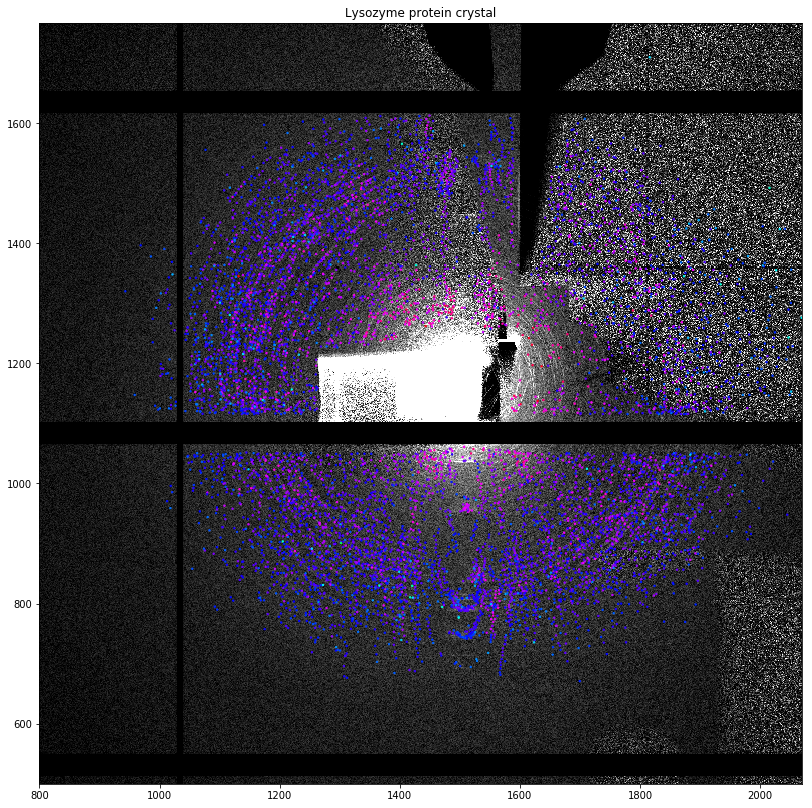

In [86]:
%matplotlib inline
plt.figure(figsize=(14, 14))
plt.imshow(lysdata.sum(axis=0), vmin=100, vmax=3000, cmap='gist_gray')
plt.scatter(lyssum[:, 0], lyssum[:, 1], s=2, c=np.log(lyssumints - lyssumints.min() + 1.0), cmap='hsv')
plt.xlim((lysroi.roi[2], lysroi.roi[3]))
plt.ylim((lysroi.roi[0], lysroi.roi[1]))
plt.title('Lysozyme protein crystal')
plt.show()